# Policy classifier
First try: bag of words (n-grams with logistic regression and k-fold cross-validation, with k set to 10).

## Importing the dataset and cleaning
We start by cleaning the data from the CSV. I could just save the cleaned csv but w/e

In [18]:
# Import and clean data
import pandas as pd
df = pd.read_csv('dataset/1339_with_titles.csv')

# check that there's no html
for row in df.iterrows():
    if '<' in str(row[1]) and '>' in str(row[1]):
        print(row)

In [19]:
# Remove markdown and various symbols in policy_text
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"\n", " ")
    df[text_field] = df[text_field].str.lower()
    return df

def extract_terms_from_url(df, url_field):
    new_column = list()
    for i, row in df.iterrows():
        # split url by '/'
        terms = row[url_field].split('/')
        # first 8 terms are domain-related, only get the rest
        new_column.append(' '.join(terms[8:]))
    new = pd.DataFrame(new_column, columns=['url_features'])
    df['url_features'] = new
    df = standardize_text(df, 'url_features')
    df['url_features'] = df['url_features'].str.replace(r"shtml", "")
    df['url_features'] = df['url_features'].str.replace(r"html", "")
    df['url_features'] = df['url_features'].str.replace(r"asp", "")
    df['url_features'] = df['url_features'].str.replace(r"php", "")
    df['url_features'].fillna('', inplace=True)

    return df

standard_df = standardize_text(df, "policy_text")
standard_df = standardize_text(df, "title")
standard_df = standardize_text(df, "link_text")
#standard_df = extract_terms_from_url(df, "policy_snapshot_url")
#standard_df = standard_df.drop_duplicates(['policy_text', 'title'])
standard_df['title'].fillna('', inplace=True)
standard_df.tail()

,policy_snapshot_url,year,season,title,homepage_snapshot_url,is_policy,link_text,policy_text,site_url
1434,https://web.archive.org/web/20051210033941id_/...,2005,B,the daily motivator no nonsense policies,https://web.archive.org/web/20050930235502id_/...,0,privacy statement,subscribe daily motivator faq ...,http://greatday.com
1435,https://web.archive.org/web/20141120055525id_/...,2014,B,privacy policy,https://web.archive.org/web/20141002004612id_/...,0,privacy policy,"terms of use welcome to valuenotes, which inc...",http://indianotes.com
1436,https://web.archive.org/web/20150502174147id_/...,2015,A,allstarplr privacy,https://web.archive.org/web/20150327005425id_/...,1,privacy,privacy ...,http://allstarplr.com
1437,https://web.archive.org/web/20121102231220id_/...,2012,B,privacy policy,https://web.archive.org/web/20121001032822id_/...,1,privacy policy,privacy policy for tinyhouseblog com the priv...,http://tinyhouseblog.com
1438,https://web.archive.org/web/20140517133144id_/...,2014,A,our privacy policy paksmile com,https://web.archive.org/web/20140111042002id_/...,1,privacy policy,we recognize that privacy of your personal inf...,http://paksmile.com


We continue the cleaning process by standardizing the text, removing the symbols, and special characters.

In [20]:
standard_df.groupby('is_policy').count()

,policy_snapshot_url,year,season,title,homepage_snapshot_url,link_text,policy_text,site_url
is_policy,,,,,,,,
0,266,266,266,266,266,266,266,266
1,1173,1173,1173,1173,1173,1173,1173,1173


## Getting the model's input data
- X: TF-IDF bag of words with n-grams ranging from unigrams to 9-grams. We further clean the text by filtering out stop-words -- from Scikit Learn's English vocabulary of stop-words.
- y: policy labels defined manually

## Cross-validation

In [21]:
# Train with cross-validation and classify
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import KFold

from scipy import interp
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-whitegrid')
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score, recall_score


def get_metrics(y_true, y_scores, thresholds):    
    '''Get precision, recall scores with given thresholds'''
    precision, recall = list(), list()
    assert(y_true.shape == y_scores.shape)
    for t in thresholds:
        y_pred = np.zeros(y_scores.shape)
        positive = np.where(y_scores > t)
        y_pred[positive] = 1
        p = precision_score(y_true, y_pred)
        precision.append(p)
        r = recall_score(y_true, y_pred)
        recall.append(r)
    return precision, recall

def train_cross_validation(classifier, kf, X, y, rf=False, real_thresholds=None):
    # metrics
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    y_scores_list = []
    real_precision = []
    real_recall = []
    y_scores_indices = []

    # cross-validation
    for i, (train, test) in enumerate(kf.split(X, y)):
        # get classification results
        if rf is False:
            y_scores = classifier.fit(X[train], y[train]).decision_function(X[test])
        else:
            y_scores = classifier.fit(X[train], y[train]).predict_proba(X[test])[:, 1]
        # gather some metrics
        # get ROC and AUC (with pre-defined thresholds) -- from sklearn tutorial
        fpr, tpr, _ = roc_curve(y[test], y_scores)
        interp_tpr = interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))
        y_scores_list.append(y_scores)
        if real_thresholds is not None:
            # get metrics that I'll use for evaluation
            prec, rec = get_metrics(y[test], y_scores, real_thresholds)
            real_precision.append(prec)
            real_recall.append(rec)
            assert(y_scores.shape == test.shape)
            y_scores_indices.append(test)
    # final training
    classifier.fit(X, y)
        
    return (y_scores_list, tprs, aucs, mean_fpr, real_precision,
           real_recall, y_scores_indices)

## Model evaluation
We evaluate the model in the following. The mean ROC is 0.93 and the average precision score after cross-validation is 0.98. Maybe we can do better with more complex models. But before giving up on logistic regression, we try other things. See below.

In [22]:
def evaluate_model_cross_validation(tprs, aucs, mean_fpr,
                                   real_precision, real_recall, thresholds):
    # Evaluation
    mean_prec = np.mean(real_precision, axis=0)
    mean_rec = np.mean(real_recall, axis=0)
    
    # print avg precision-recall for each threshold
    for precision, recall, t in zip(mean_prec, mean_rec, thresholds):
        print("Threshold %.4f\tprecision %.4f\t recall %.4f" % (t,
                                                               precision, recall))
    # plot avg ROC (from sklearn tutorial)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, #color='r',
            label='Random', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, #color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, #color='grey',
                    alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.title('ROC')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="lower right")
    plt.show()
    
#evaluate_model_cross_validation(tprs, aucs, prec, rec, ap, mean_fpr)

In [24]:
from sklearn.model_selection import StratifiedKFold

def crossval_and_evaluate(model, X_list, y, thresholds, rf=True):
    '''Performs cross validation on given models and training sets, using given thresholds.
    
        Args:
            model: dict of models
            X_list: dict of pre-processed training sets (sorry for confusion in name)
            y: testing set
            thresholds: list of thresholds to try
            rf: bool True if model is random forest classifier
            
        Return: evaluation data of models after cross-validation (dict)'''
    # create dict of 
    model_data = dict()
    # because I settled with unigrams-to-fourgrams, I modified this line to just include that one training set
    # normally I would loop through the items of the X_list dictionary
    for key, X in {'1-to-4grams':X_list['1-to-4grams'].todense()}.items():
        print(key)
        model_data[key] = dict()
        # save model
        model_data[key]['model'] = model
        # get cross-val data
        y_scores, tprs, aucs, mean_fpr, real_precision, \
           real_recall, y_scores_indices = train_cross_validation(model, StratifiedKFold(n_splits=10),
                                                            X, y, rf=rf, real_thresholds=thresholds)
        # save eval data
        model_data[key]['precision'] = real_precision
        model_data[key]['recall'] = real_recall
        model_data[key]['thresholds'] = thresholds
        model_data[key]['y_scores'] = y_scores
        model_data[key]['y_scores_indices'] = y_scores_indices
        # print cross-val data
        evaluate_model_cross_validation(tprs, aucs, 
                                        mean_fpr,
                                        real_precision, 
                                        real_recall,
                                        thresholds)                  
    return model_data

## TF Vectorizer filtering out _p_ rare words

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

#tf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,4), use_idf=False)
c_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1), min_df=0.01)
X_titles = c_vectorizer.fit_transform(standard_df['title'].values)
#X_titles_tf = TfidfTransformer(use_idf=False).fit_transform(X_titles)
#X_link_text = c_vectorizer.fit_transform(standard_df['link_text'].values)
#X_link_text_tf = TfidfTransformer(use_idf=False).fit_transform(X_link_text)
#X_url = c_vectorizer.fit_transform(standard_df['url_features'])
#X_url_tf = TfidfTransformer(use_idf=False).fit_transform(X_url)

p = 0.01 # min rate of documents                                                   
y = standard_df['is_policy'].values
X_tfs = dict()

for i in range(1,5):
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,i), 
                                 use_idf=False, min_df=p)
    key = '1-to-%dgrams' % i
    X_tfs[key] = vectorizer.fit_transform(standard_df['policy_text'])

# Cross validation and evaluation with _p_ rare words filtered out

### Logistic regression _p_ rare words filtered out

1-to-4grams


/Users/el/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/el/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/el/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/el/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/el/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Us

Threshold 0.9000	precision 0.9608	 recall 0.9557
Threshold 0.9050	precision 0.9608	 recall 0.9557
Threshold 0.9100	precision 0.9608	 recall 0.9557
Threshold 0.9150	precision 0.9608	 recall 0.9540
Threshold 0.9200	precision 0.9608	 recall 0.9540
Threshold 0.9250	precision 0.9616	 recall 0.9540
Threshold 0.9300	precision 0.9623	 recall 0.9540
Threshold 0.9350	precision 0.9623	 recall 0.9540
Threshold 0.9400	precision 0.9623	 recall 0.9523
Threshold 0.9450	precision 0.9640	 recall 0.9523
Threshold 0.9500	precision 0.9647	 recall 0.9514
Threshold 0.9550	precision 0.9647	 recall 0.9514
Threshold 0.9600	precision 0.9655	 recall 0.9514
Threshold 0.9650	precision 0.9655	 recall 0.9514
Threshold 0.9700	precision 0.9655	 recall 0.9514
Threshold 0.9750	precision 0.9663	 recall 0.9514
Threshold 0.9800	precision 0.9663	 recall 0.9514
Threshold 0.9850	precision 0.9663	 recall 0.9506
Threshold 0.9900	precision 0.9663	 recall 0.9506
Threshold 0.9950	precision 0.9670	 recall 0.9506


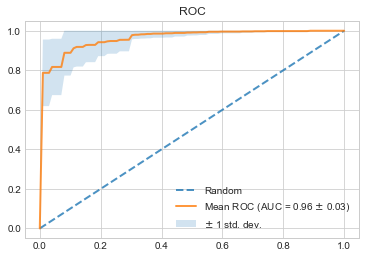

In [26]:
thresholds_lr_top = np.arange(0.9, 1, 0.005)
model_lr_top = LogisticRegression(random_state=0, max_iter=500)
model_data_lr_top = crossval_and_evaluate(model_lr_top, X_tfs, y, thresholds_lr_top, rf=False)

### Random forest _p_ rare words filtered out

1-to-4grams


/Users/el/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/el/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/el/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/el/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/el/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/el/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarni

Threshold 0.5000	precision 0.9433	 recall 0.9668
Threshold 0.5050	precision 0.9450	 recall 0.9668
Threshold 0.5100	precision 0.9449	 recall 0.9659
Threshold 0.5150	precision 0.9464	 recall 0.9642
Threshold 0.5200	precision 0.9464	 recall 0.9642
Threshold 0.5250	precision 0.9472	 recall 0.9642
Threshold 0.5300	precision 0.9505	 recall 0.9625
Threshold 0.5350	precision 0.9504	 recall 0.9617
Threshold 0.5400	precision 0.9528	 recall 0.9608
Threshold 0.5450	precision 0.9528	 recall 0.9608
Threshold 0.5500	precision 0.9528	 recall 0.9608
Threshold 0.5550	precision 0.9544	 recall 0.9600
Threshold 0.5600	precision 0.9552	 recall 0.9591
Threshold 0.5650	precision 0.9559	 recall 0.9583
Threshold 0.5700	precision 0.9582	 recall 0.9574
Threshold 0.5750	precision 0.9589	 recall 0.9574
Threshold 0.5800	precision 0.9588	 recall 0.9557
Threshold 0.5850	precision 0.9597	 recall 0.9557
Threshold 0.5900	precision 0.9604	 recall 0.9548
Threshold 0.5950	precision 0.9604	 recall 0.9531
Threshold 0.6000	pre

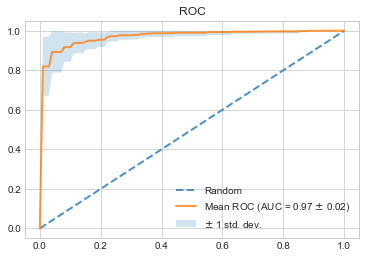

In [27]:
from sklearn.ensemble import RandomForestClassifier
import scipy.sparse as sparse

X_tfs['1-to-4grams'] = sparse.hstack((X_tfs['1-to-4grams'], X_titles))

thresholds_rfc_top = np.arange(0.5, 1, 0.005)
model_rfc_top = RandomForestClassifier(max_depth=15, max_features= 0.3, min_samples_leaf=3,
                                    n_estimators=100, class_weight='balanced', n_jobs=4)
model_data_rfc_top = crossval_and_evaluate(model_rfc_top, X_tfs, y, thresholds_rfc_top)

# Check results of best-performing model after _p_ rare words out
Given the results in the previous cell, we now look at the behavior of the Random Forest Classifiers (which outperforms the Logistic Regression models) with the most promising thresholds.

The criteria for these choices are given by precision ~99% and recall > 90%

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
# we start with the most promising set of features (from unigrams to fourgrams)
model = model_data_rfc_top['1-to-4grams']

# small selection of threshold that seem to perform well
chosen_thresholds = [0.73]

def print_misclassified_examples(y, y_true_indices, y_pred):
    '''Creates and prints list of misclassifications'''
    cursor = 0
    misclassified_indices = list()
    # mask of indices included in cross-val round
    mask = np.array([False]*y.shape[0])
    mask[y_true_indices] = True
    for index in y_true_indices:
        # if index included in cross-val round
        if mask[index]:
            # if misclassified
            if y[index] != y_pred[cursor]:
                # save as misclassified
                misclassified_indices.append(index)
            cursor += 1
            
    print("Total examples:", y_pred.shape[0])
    print("Total misclassified:", len(misclassified_indices))
    print("Index and (correct) label of misclassified examples:\n", 
              standard_df.iloc[misclassified_indices]['is_policy'])

# for each chosen threshold
for t in chosen_thresholds:
    print("Threshold: %.3f\n" % (t))
    # for each cross-val round
    for i, scores in enumerate(model['y_scores']):
        # get binary predictions based on threshold
        y_pred = np.zeros(scores.shape)
        positive = np.where(scores > t)
        y_pred[positive] = 1
        print(y_pred.shape)
        # get indices used in cross-val round
        y_true_indices = model['y_scores_indices'][i]
        # get predictions in cross-val round
        y_true = y[y_true_indices]
        print("__ ROUND %d __" % i)
        print("Confusion matrix:")
        print(confusion_matrix(y_true, y_pred))
        #precision, recall = get_metrics(y_true, scores, [t])
        print_misclassified_examples(y, y_true_indices, y_pred)
        
    print("\n\n\n")

Threshold: 0.730

(145,)
__ ROUND 0 __
Confusion matrix:
[[ 21   6]
 [  7 111]]
Total examples: 145
Total misclassified: 13
Index and (correct) label of misclassified examples:
 22     0
35     0
41     0
44     0
57     1
64     0
71     1
94     0
105    1
111    1
129    1
148    1
179    1
Name: is_policy, dtype: int64
(145,)
__ ROUND 1 __
Confusion matrix:
[[ 24   3]
 [  9 109]]
Total examples: 145
Total misclassified: 12
Index and (correct) label of misclassified examples:
 101    0
110    0
133    0
226    1
239    1
247    1
252    1
270    1
282    1
306    1
314    1
322    1
Name: is_policy, dtype: int64
(145,)
__ ROUND 2 __
Confusion matrix:
[[ 23   4]
 [ 14 104]]
Total examples: 145
Total misclassified: 18
Index and (correct) label of misclassified examples:
 176    0
228    0
238    0
245    0
340    1
348    1
354    1
389    1
395    1
396    1
434    1
445    1
452    1
454    1
458    1
463    1
464    1
465    1
Name: is_policy, dtype: int64
(144,)
__ ROUND 3 __
Conf

## Save classifier + selected threshold

In [25]:
import pickle
pickle.dump({'model': model_rfc_top, 'threshold': 0.735,
            'policy_text_vectorizer': vectorizer,
            'title_vectorizer': c_vectorizer}, open('classifier.p', 'wb'))